In [173]:
import nfl_data_py as nfl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
import requests

In [435]:
def get_boxscores(year):
    url = f"https://www.pro-football-reference.com/years/{year}/games.htm#games"
    response = requests.get(url)
    soup = BeautifulSoup(response.text)
    
    table = soup.find("table")
    headings = [th.get_text() for th in table.find("tr").find_all("th")]

    datasets = []
    for row in table.find_all("tr")[1:]:
        r = row.find_all("th") + row.find_all("td")
        if headings[0] == r[0].get_text():
            continue
        dataset = zip(headings, (td.get_text() for td in r))
        datasets.append({d[0]: d[1] for d in dataset})
    return datasets

def get_playbyplay(year):
    return nfl.import_pbp_data([year])
    
team_maps = {
    v: k for k, v in {
    'Detroit Lions': 'DET', 'Kansas City Chiefs': 'KC', 'Atlanta Falcons': 'ATL', 'Carolina Panthers': 'CAR',
    'Cleveland Browns': 'CLE', 'Cincinnati Bengals': 'CIN', 'Jacksonville Jaguars': 'JAX', 'Indianapolis Colts': 'IND',
    'Washington Commanders': 'WAS', 'Arizona Cardinals': 'ARI', 'Baltimore Ravens': 'BAL', 'Houston Texans': 'HOU',
    'Tampa Bay Buccaneers': 'TB', 'Minnesota Vikings': 'MIN', 'New Orleans Saints': 'NO', 'Tennessee Titans': 'TEN',
    'San Francisco 49ers': 'SF', 'Pittsburgh Steelers': 'PIT', 'Green Bay Packers': 'GB', 'Chicago Bears': 'CHI',
    'Las Vegas Raiders': 'LV', 'Denver Broncos': 'DEN', 'Miami Dolphins': 'MIA', 'Los Angeles Chargers': 'LAC',
    'Philadelphia Eagles': 'PHI', 'New England Patriots': 'NE', 'Los Angeles Rams': 'LA', 'Seattle Seahawks': 'SEA',
    'Dallas Cowboys': 'DAL', 'New York Giants': 'NYG', 'New York Jets': 'NYJ', 'Buffalo Bills': 'BUF'
    }.items()
}

In [487]:
dfs = [get_playbyplay(year) for year in range(2008, 2024)]

2008 done.
Downcasting floats.
2009 done.
Downcasting floats.
2010 done.
Downcasting floats.
2011 done.
Downcasting floats.
2012 done.
Downcasting floats.
2013 done.
Downcasting floats.
2014 done.
Downcasting floats.
2015 done.
Downcasting floats.
2016 done.
Downcasting floats.
2017 done.
Downcasting floats.
2018 done.
Downcasting floats.
2019 done.
Downcasting floats.
2020 done.
Downcasting floats.
2021 done.
Downcasting floats.
2022 done.
Downcasting floats.
2023 done.
Downcasting floats.


In [488]:
df = dfs[-1]
gdf = df[df['game_id']=="2023_06_WAS_ATL"].reset_index()
cols = nfl.see_pbp_cols()
for col in cols:
    print(f"{col}: {gdf.iloc[-1][col]}")

play_id: 4207.0
game_id: 2023_06_WAS_ATL
old_game_id: 2023101501
home_team: ATL
away_team: WAS
season_type: REG
week: 6
posteam: WAS
posteam_type: away
defteam: ATL
side_of_field: None
yardline_100: nan
game_date: 2023-10-15
quarter_seconds_remaining: 0.0
half_seconds_remaining: 0.0
game_seconds_remaining: 0.0
game_half: Half2
quarter_end: 0.0
drive: 23.0
sp: 0.0
qtr: 4.0
down: nan
goal_to_go: 0.0
time: 00:00
yrdln: None
ydstogo: 0.0
ydsnet: -1.0
desc: END GAME
play_type: None
yards_gained: nan
shotgun: 0.0
no_huddle: 0.0
qb_dropback: nan
qb_kneel: 0.0
qb_spike: 0.0
qb_scramble: 0.0
pass_length: None
pass_location: None
air_yards: nan
yards_after_catch: nan
run_location: None
run_gap: None
field_goal_result: None
kick_distance: nan
extra_point_result: None
two_point_conv_result: None
home_timeouts_remaining: 0.0
away_timeouts_remaining: 3.0
timeout: nan
timeout_team: None
td_team: None
td_player_name: None
td_player_id: None
posteam_timeouts_remaining: 3.0
defteam_timeouts_remaining: 0

In [489]:
class Team:
    def __init__(self, name):
        self.name = name
        self.schedule = []
    
    def __str__(self):
        return f"{self.name} ({self.wins()}-{self.games()-self.wins()})"
    
    def games(self):
        return len(self.schedule)
    
    def wins(self):
        return sum([g.result for g in self.schedule])
    
class Game:
    def __init__(self, gd):
        self.week = gd['week']
        self.opponent = gd['opponent']
        self.ptsf = gd['ptsf']
        self.ptsa = gd['ptsa']
        self.wpa_pass = gd['wpa_pass']
        self.wpa_passdef = gd['wpa_passdef']
        self.wpa_rush = gd['wpa_rush']
        self.wpa_rushdef = gd['wpa_rushdef']
        self.game_id = gd['game_id']
        
        if self.ptsf > self.ptsa:
            self.result = 1
            self.letter = 'W'
        elif self.ptsf < self.ptsa:
            self.result = 0
            self.letter = "L"
        else:
            self.result = 0.5
            self.letter = "T"
            
        self.garbage_minutes = gd['garbage_minutes']
        if self.letter == "L":
            self.garbage_minutes = -self.garbage_minutes
            
            
def parse_game(gdf):
    lowest_time_in_play = 3600
    home_rush_wpa = 0
    away_rush_wpa = 0
    home_pass_wpa = 0
    away_pass_wpa = 0
    for i in range(2, gdf.shape[0]):        
        play = gdf.loc[i]
        
        if play['rush_attempt'] == 1 and not np.isnan(play.wpa):
            if play.posteam_type == "home":
                home_rush_wpa += play['wpa']
            if play.posteam_type == "away":
                away_rush_wpa += play['wpa']
        elif play.pass_attempt == 1 and not np.isnan(play.wpa):
            if play.posteam_type == "home":
                home_pass_wpa += play['wpa']
            if play.posteam_type == "away":
                away_pass_wpa += play['wpa']
        
        time_remaining = play['game_seconds_remaining']
        
        hwp = play['home_wp']        
        if 0.025 < hwp < 0.975 and time_remaining < lowest_time_in_play:
            lowest_time_in_play = time_remaining
            
        if play['game_half'] == "Overtime":
            lowest_time_in_play = 0
            break
            
    final_play = gdf.iloc[-1]
    return {
        "home_team": final_play['home_team'],
        "away_team": final_play['away_team'],
        "garbage_minutes": lowest_time_in_play / 60,
        "home_rush_wpa": home_rush_wpa,
        "away_rush_wpa": away_rush_wpa,
        "home_pass_wpa": home_pass_wpa,
        "away_pass_wpa": away_pass_wpa,
        "home_score": final_play['home_score'],
        "away_score": final_play['away_score'],
        "game_id": final_play['game_id'],
        "week": final_play['week']
    }

def add_game_data(team, opponent, teamtype, gd):
    if teamtype == "home":
        opptype = "away"
    else:
        opptype = "home"
        
    return Game({
        "opponent": opponent,
        "wpa_pass": gd[teamtype+'_pass_wpa'], "wpa_passdef": gd[opptype+'_pass_wpa'],
        "wpa_rush": gd[teamtype+'_rush_wpa'], "wpa_rushdef": gd[opptype+'_rush_wpa'],
        "ptsf": gd[teamtype+'_score'], "ptsa": gd[opptype+'_score'],
        "garbage_minutes": gd['garbage_minutes'],
        "game_id": gd['game_id'], "week": gd['week']
    })

In [490]:
def get_season_data(season_df):
    teams = {}
    games = season_df.game_id.unique()
    for game in games:
        gdf = season_df[season_df['game_id']==game].reset_index()
        
        home_name = gdf.loc[0]["home_team"]
        away_name = gdf.loc[0]["away_team"]

        if home_name not in teams:
            teams[home_name] = Team(home_name)
        if away_name not in teams:
            teams[away_name] = Team(away_name)
        
        game_data = parse_game(gdf)
        
        teams[home_name].schedule.append(add_game_data(teams[home_name], teams[away_name], "home", game_data))
        teams[away_name].schedule.append(add_game_data(teams[away_name], teams[home_name], "away", game_data))
        
    return teams

In [491]:
def single_week_model_data(teams, season_df, predict_week):
    for name in teams:
        opp_wpa_pass = []
        opp_wpa_passdef = []
        opp_wpa_rush = []
        opp_wpa_rushdef = []
        
        for game in teams[name].schedule:
            if game.week >= predict_week:
                continue
            
            for oppgame in game.opponent.schedule:
                if oppgame.week >= predict_week:
                    continue
                    
                if oppgame.opponent.name != name:
                    opp_wpa_pass.append(oppgame.wpa_pass)
                    opp_wpa_passdef.append(oppgame.wpa_passdef)
                    opp_wpa_rush.append(oppgame.wpa_rush)
                    opp_wpa_rushdef.append(oppgame.wpa_rushdef)

            game.wpa_pass_oe = game.wpa_pass - np.mean(opp_wpa_pass)
            game.wpa_passdef_oe = game.wpa_passdef - np.mean(opp_wpa_passdef)
            game.wpa_rush_oe = game.wpa_rush - np.mean(opp_wpa_rush)
            game.wpa_rushdef_oe = game.wpa_rushdef - np.mean(opp_wpa_rushdef)
            
    for name in teams:
        team = teams[name]
        """team.data = {
            "wpa_pass_oe": np.mean([g.wpa_pass_oe for g in team.schedule if g.week < predict_week]),
            "wpa_passdef_oe": np.mean([g.wpa_passdef_oe for g in team.schedule if g.week < predict_week]),
            "wpa_rush_oe": np.mean([g.wpa_rush_oe for g in team.schedule if g.week < predict_week]),
            "wpa_rushdef_oe": np.mean([g.wpa_rushdef_oe for g in team.schedule if g.week < predict_week]),
            "avg_garbage_minutes": np.mean([g.garbage_minutes for g in team.schedule if g.week < predict_week]),
            #"std_garbage_minutes": np.std([g.garbage_minutes for g in team.schedule if g.week < predict_week])
        }"""
        team.data = {
            "wpa_pass": np.mean([g.wpa_pass for g in team.schedule if g.week < predict_week]),
            "wpa_passdef": np.mean([g.wpa_passdef for g in team.schedule if g.week < predict_week]),
            "wpa_rush": np.mean([g.wpa_rush for g in team.schedule if g.week < predict_week]),
            "wpa_rushdef": np.mean([g.wpa_rushdef for g in team.schedule if g.week < predict_week]),
            "avg_garbage_minutes": np.mean([g.garbage_minutes for g in team.schedule if g.week < predict_week]),
            #"std_garbage_minutes": np.std([g.garbage_minutes for g in team.schedule if g.week < predict_week])
        }
        
        
    #df1["total_wpa_off"] = df1["wpa_pass"] + df1["wpa_rush"]
    #df1["total_wpa_def"] = -df1["wpa_passdef"] - df1["wpa_rushdef"]
    
    tdf = pd.DataFrame()
    predict_week_games = season_df[season_df['week'] == predict_week].game_id.unique()
    for game in predict_week_games:
        gdf = season_df[season_df['game_id']==game].reset_index()
        
        row = {"game_id": game}
        home = teams[gdf.iloc[0].home_team]
        row.update({f"home_{key}": home.data[key] for key in home.data})
        away = teams[gdf.iloc[0].away_team]
        row.update({f"away_{key}": away.data[key] for key in away.data})
        
        for g in home.schedule:
            if g.week == predict_week:
                row['home_win'] = g.result
                tdf = tdf.append(row, ignore_index=True)
                break

    return tdf

def get_model_data(team_data, season_df, min_week, max_week):
    tdf = pd.DataFrame()
    for week in range(min_week, max_week+1):
        tdf = tdf.append(single_week_model_data(team_data, season_df, predict_week=week))
    tdf = tdf.reset_index(drop=True)
    return tdf

In [492]:
big_train = pd.DataFrame()
for sdf in dfs[:-1]:
    team_data = get_season_data(sdf)
    big_train = big_train.append(get_model_data(team_data, sdf, 9, 15)).reset_index(drop=True)
    
big_train

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in less


,away_avg_garbage_minutes,away_wpa_pass,away_wpa_passdef,away_wpa_rush,away_wpa_rushdef,game_id,home_avg_garbage_minutes,home_win,home_wpa_pass,home_wpa_passdef,home_wpa_rush,home_wpa_rushdef
0,4.242857,0.149647,0.107777,-0.060652,-0.009280,2008_09_ARI_STL,-4.290476,0.0,-0.064534,0.038488,-0.110705,0.069351
1,0.771429,0.092819,0.151745,-0.030465,-0.063193,2008_09_ATL_OAK,-6.628571,0.0,-0.175851,-0.095749,-0.095378,0.031592
2,-0.630952,-0.077996,-0.134794,0.009942,-0.163633,2008_09_BAL_CLE,-3.880952,0.0,0.022583,0.084150,-0.083934,0.020655
3,0.845833,0.157696,0.066582,0.029230,-0.110816,2008_09_DAL_NYG,4.666667,1.0,0.251560,0.001776,-0.023818,-0.072221
4,-8.030952,-0.190885,0.231309,-0.077709,-0.046129,2008_09_DET_CHI,4.735714,1.0,0.009640,-0.130306,-0.068558,-0.114537
...,...,...,...,...,...,...,...,...,...,...,...,...
1567,-2.225641,0.019425,0.005327,0.049653,0.057923,2022_15_NYG_WAS,-1.720513,0.0,-0.057142,-0.154819,0.033441,0.009326
1568,7.221795,0.074891,-0.099614,0.228457,0.007399,2022_15_PHI_CHI,-2.246154,0.0,-0.178174,0.129337,0.121401,0.035808
1569,-3.525641,-0.038162,0.062802,0.023916,0.033005,2022_15_PIT_CAR,-1.834615,0.0,-0.112633,0.027295,0.047601,-0.027139
1570,5.437179,0.100799,-0.058008,0.028350,-0.023173,2022_15_SF_SEA,-0.039744,0.0,0.075805,0.098227,0.068232,0.030706


In [522]:
no_ties = big_train[big_train['home_win'].isin([0.0, 1.0])]

X_train = no_ties.drop("game_id", axis=1).drop("home_win", axis=1)
y_train = no_ties["home_win"]

model = LogisticRegression()
model.fit(X_train, y_train)

test_df = get_model_data(team_data, dfs[-1], 11, 15)
X_test = test_df.drop("game_id", axis=1).drop("home_win", axis=1)
y_test = test_df["home_win"]

no_ties["predicted"] =  model.predict(X_train)
test_df["predicted"] = y_pred = model.predict(X_test)

test_df['probability'] = [j for i, j in model.predict_proba(X_test)]

for n, m in zip(X_train.columns, model.coef_[0]):
    print(f"{n:>30}: {m}")
print(f"{'Intercept':>30}: {model.intercept_}")

"""for n, m in zip(X_train.columns, model.feature_importances_):
    print(f"{n:>30}: {m}")"""

      away_avg_garbage_minutes: -0.06775470303279454
                 away_wpa_pass: -1.7643400509419946
              away_wpa_passdef: 0.34748755624805344
                 away_wpa_rush: -1.5248868521548427
              away_wpa_rushdef: 0.6531072328340043
      home_avg_garbage_minutes: 0.1056845927033491
                 home_wpa_pass: 1.2439116732651927
              home_wpa_passdef: 0.023962261025467602
                 home_wpa_rush: 0.7936556295285452
              home_wpa_rushdef: -0.8991831906453783
                     Intercept: [0.21727076]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


'for n, m in zip(X_train.columns, model.feature_importances_):\n    print(f"{n:>30}: {m}")'

In [526]:
no_ties["correct"] = 1 - np.abs(no_ties['home_win'] - no_ties['predicted'])
np.mean(no_ties['correct'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.6477345245692406

In [527]:
test_df["correct"] = 1 - np.abs(test_df['home_win'] - test_df['predicted'])
print(np.mean(test_df['correct']))
test_df[['game_id', 'home_win', 'predicted', 'probability', 'correct']].sort_values("probability")

0.644927536231884


,game_id,home_win,predicted,probability,correct
36,2023_13_KC_GB,1.0,0.0,0.261370,0.0
19,2023_12_KC_LV,1.0,0.0,0.294447,0.0
66,2023_15_SF_ARI,0.0,0.0,0.296383,1.0
18,2023_12_JAX_HOU,0.0,0.0,0.338864,1.0
64,2023_15_PHI_SEA,0.0,0.0,0.339990,1.0
...,...,...,...,...,...
44,2023_14_HOU_NYJ,0.0,1.0,0.733238,0.0
47,2023_14_LA_BAL,1.0,1.0,0.746339,1.0
7,2023_11_NYJ_BUF,1.0,1.0,0.769434,1.0
24,2023_12_PIT_CIN,1.0,1.0,0.790282,1.0


In [312]:
import inspect
game1 = team_data['SEA'].schedule[1]
for key, value in inspect.getmembers(game1):
    if key[0] != "_":
        print(f"{key}: {value}")

game_id: 2023_02_SEA_DET
garbage_minutes: 0.0
letter: W
opponent: DET (14-6)
ptsa: 31
ptsf: 37
result: 1
week: 2
wpa_pass: 0.32651524245738983
wpa_pass_oe: 0.19071360776716675
wpa_passdef: 0.016266919672489166
wpa_passdef_oe: -0.01621151257023922
wpa_rush: 0.11545314895920455
wpa_rush_oe: 0.06593196859015465
wpa_rushdef: -0.15482516586780548
wpa_rushdef_oe: -0.12950104865767234


,team,epa_pass_oe,epa_passdef_oe,epa_rush_oe,epa_rushdef_oe,garbage_minutes,garbage_minutes_stdev
0,ARI,-5.038588,4.661572,2.181294,1.185558,-3.290196,6.828265
1,ATL,-1.675666,-1.397631,-2.001779,-2.999025,-0.936275,4.196152
2,BAL,2.646528,-6.737703,3.155729,-0.118821,7.086842,10.396432
3,BUF,8.168502,-1.881531,5.309479,1.170160,5.346491,8.378163
4,CAR,-10.410472,-0.470357,0.254234,2.074559,-5.647059,6.272320
5,CHI,-4.915677,-0.586769,3.214642,-1.965345,-2.568627,10.148468
6,CIN,0.977871,4.042197,-0.386681,2.053100,-1.463725,11.771551
7,CLE,-8.459653,-7.047102,-2.122986,-1.935021,-0.001852,11.258898
8,DAL,9.268112,-2.027025,1.892623,-1.230292,6.700926,16.603549
9,DEN,0.333795,2.632787,-0.420780,0.736164,-1.898039,8.205747


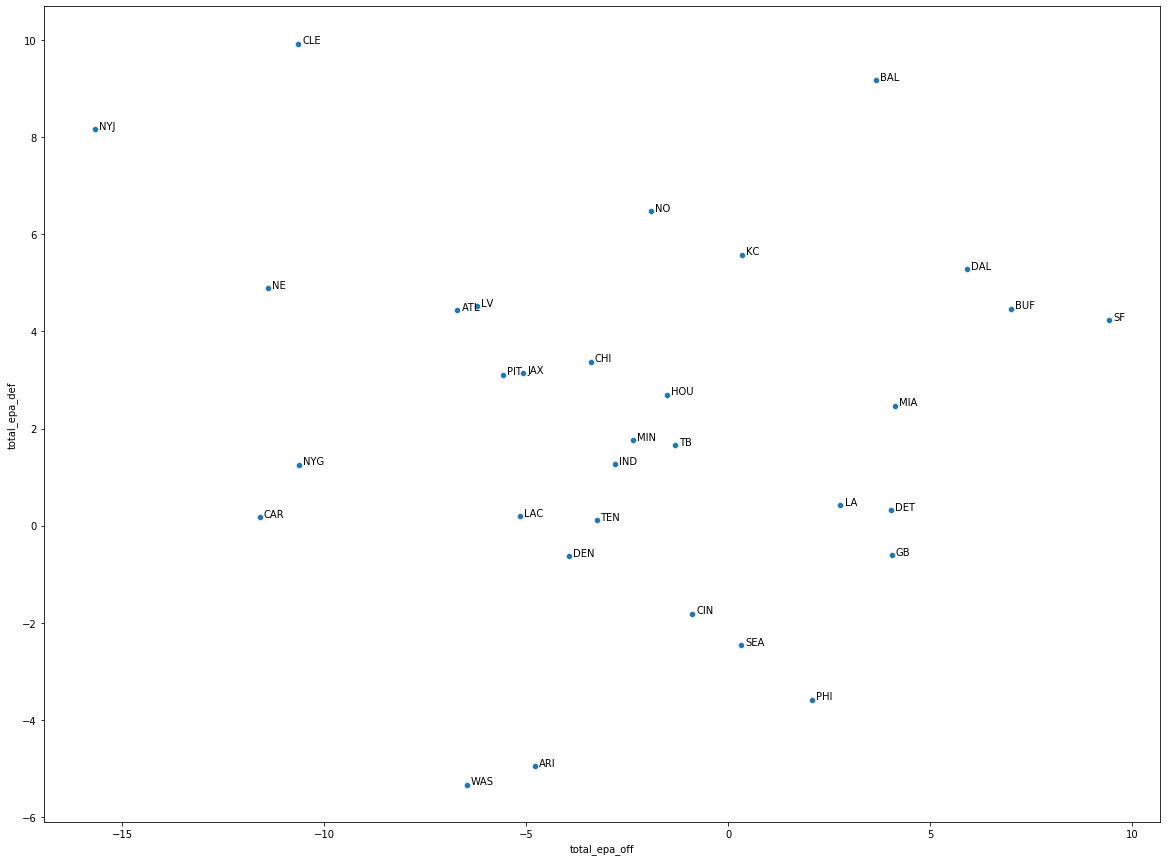

In [57]:
def label_point(x, y, val, ax, adj):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+adj, point['y'], str(point['val']))
        
X = "total_epa_off"
Y = "total_epa_def"

plt.figure(figsize=(20, 15))
sns.scatterplot(df, x = X, y = Y)
label_point(df[X], df[Y], df["team"], plt.gca(), 0.1)